In [1]:
#imports

import PyPDF2
import re
import glob
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from gensim import corpora, models, matutils
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pickle

sns.set(style = "darkgrid")
%matplotlib inline

In [2]:
unpickle_speeches = open("speech_tokens.txt", "rb")
speech_tokens = pickle.load(unpickle_speeches)

unpickle_reports = open("report_tokens.txt", "rb")
report_tokens = pickle.load(unpickle_reports)

### Pre-Modeling Work:

- [x] Create raw text corpus
- [x] Create corpus with \n's removed
- [x] Convert both corpi into dataframes
- [x] Tokenize documents on paragraphs
  - [x] 3+ \n's for speeches? seems pretty good!
  - [x] roman numerals and numbers for reports? I think I've got it where I want it for now...
- [x] Preprocess corpi:
  - [x] remove stop words
  - [x] lemmatize
  - [x] stem
  - [x] min_df value?
  - [x] max_df value?
- [x] CountVectorize both corpi
- [x] TfidfVectorize both corpi
- [ ] Named Entity Recognition?

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/mattiboi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
lemmatizer = WordNetLemmatizer()
word_stemmer = PorterStemmer()

speeches_lem = []
speeches_stem = []

lem = map(lemmatizer.lemmatize, speech_tokens)
stem = map(word_stemmer.stem, speech_tokens)

for word in lem:
    speeches_lem.append(word)
    
for word in stem:
    speeches_stem.append(word)

In [5]:
#speeches_lem[:40]

In [6]:
#speeches_stem[:40]

In [5]:
speeches_cv = CountVectorizer(stop_words='english', min_df=.01, max_df=.99, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()), ngram_range=(1,3))
sfx = speeches_cv.fit_transform(speeches_lem)

speech_cvdf = pd.DataFrame(sfx.toarray(), columns=speeches_cv.get_feature_names())

/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
speech_cvdf.head()

,access,achieve,achieving,act,action,actions,adaptation,address,agenda,agreement,...,warming,water,way,work,working,world,world leaders,year,years,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
cosine_similarity(speech_cvdf)

array([[1.        , 0.42008403, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.42008403, 1.        , 0.14002801, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.14002801, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.16222142,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16222142, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [8]:
speeches_tfidf = TfidfVectorizer(stop_words='english', min_df=.01, max_df=.99, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()), ngram_range=(1,3))
sfx2 = speeches_tfidf.fit_transform(speeches_lem)

speech_tfidf_df = pd.DataFrame(sfx2.toarray(), columns=speeches_tfidf.get_feature_names())

/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
speech_tfidf_df.head()

,access,achieve,achieving,act,action,actions,adaptation,address,agenda,agreement,...,warming,water,way,work,working,world,world leaders,year,years,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.432454,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [10]:
cosine_similarity(speech_tfidf_df)

array([[1.        , 0.46028806, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.46028806, 1.        , 0.0959707 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0959707 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.16631194,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16631194, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [11]:
n3 = PCA(n_components=3)
n4 = PCA(n_components=4)
n18 = PCA(n_components=18)

In [12]:
n3_fit = n3.fit(speech_tfidf_df)
n4_fit = n4.fit(speech_tfidf_df)
n18_fit = n18.fit(speech_tfidf_df)

In [13]:
#n3.components_
#n4.components_
#n18.components_

In [14]:
n3_xform = n3.transform(speech_tfidf_df)
n4_xform = n4.transform(speech_tfidf_df)
n18_xform = n18.transform(speech_tfidf_df)

In [15]:
n3_explain = n3_fit.explained_variance_ratio_
n4_explain = n4_fit.explained_variance_ratio_
n18_explain = n18_fit.explained_variance_ratio_

In [16]:
n3_xform
#n4_xform
#n18_xform

array([[-0.03220029,  0.00466138, -0.07731275],
       [ 0.06095789, -0.03549434, -0.11655248],
       [ 0.92009213, -0.14132155,  0.13409426],
       ...,
       [-0.06983503, -0.02528391, -0.01005605],
       [-0.11571412, -0.0916927 ,  0.18447431],
       [ 0.06342169,  0.95066285,  0.20434573]])

In [17]:
speech_coords_3d = n3.fit_transform(speech_tfidf_df)
speech_coords_4d = n4.fit_transform(speech_tfidf_df)
speech_coords_18d = n18.fit_transform(speech_tfidf_df)

In [18]:
speeches_3d_df = pd.DataFrame(speech_coords_3d, columns = ['pc1','pc2','pc3'])

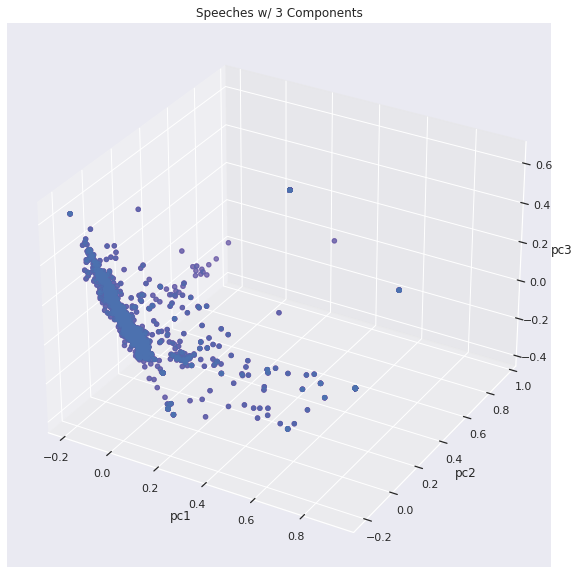

In [19]:
fig = plt.figure(figsize = (15, 10))
ax = plt.axes(projection ="3d")

x = speeches_3d_df['pc1']
y = speeches_3d_df['pc2']
z = speeches_3d_df['pc3']

ax.scatter3D(x, y, z, color = "purple")
plt.title("Speeches w/ 3 Components")

ax.set_xlabel("pc1")
ax.set_ylabel("pc2")
ax.set_zlabel("pc3")

ax.scatter(x, y, z)

plt.show()

In [20]:
sum(n3_explain)

0.11009193310090715

In [21]:
sum(n4_explain)

0.13280078518767846

In [22]:
sum(n18_explain)

0.3122602598351112

In [23]:
reports_lem = []
reports_stem = []

lem = map(lemmatizer.lemmatize, report_tokens)
stem = map(word_stemmer.stem, report_tokens)

for word in lem:
    reports_lem.append(word)
    
for word in stem:
    reports_stem.append(word)

In [24]:
reports_cv = CountVectorizer(stop_words='english', min_df=.01, max_df=.99)
rfx = reports_cv.fit_transform(reports_lem)

report_cvdf = pd.DataFrame(rfx.toarray(), columns=reports_cv.get_feature_names())

/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
cosine_similarity(report_cvdf)

array([[1.        , 0.        , 0.05357143, ..., 0.04718771, 0.09832103,
        0.04030947],
       [0.        , 1.        , 0.1118034 , ..., 0.10743337, 0.20519567,
        0.15142634],
       [0.05357143, 0.1118034 , 1.        , ..., 0.06381065, 0.10036938,
        0.10228529],
       ...,
       [0.04718771, 0.10743337, 0.06381065, ..., 1.        , 0.74745864,
        0.48042153],
       [0.09832103, 0.20519567, 0.10036938, ..., 0.74745864, 1.        ,
        0.44827876],
       [0.04030947, 0.15142634, 0.10228529, ..., 0.48042153, 0.44827876,
        1.        ]])

In [26]:
reports_tfidf = TfidfVectorizer(stop_words='english', min_df=.01, max_df=.99)
rfx2 = reports_tfidf.fit_transform(reports_lem)

report_tfidf_df = pd.DataFrame(rfx2.toarray(), columns=reports_tfidf.get_feature_names())

/home/mattiboi/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
cosine_similarity(speech_tfidf_df)

array([[1.        , 0.46028806, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.46028806, 1.        , 0.0959707 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0959707 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.16631194,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16631194, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [28]:
n3_fit_reports = n3.fit(report_tfidf_df)
n4_fit_reports = n4.fit(report_tfidf_df)
n18_fit_reports = n18.fit(report_tfidf_df)

n3_xform_report = n3.transform(report_tfidf_df)
n4_xform_report = n4.transform(report_tfidf_df)
n18_xform_report = n18.transform(report_tfidf_df)

n3_explain_report = n3_fit_reports.explained_variance_ratio_
n4_explain_report = n4_fit_reports.explained_variance_ratio_
n18_explain_report = n18_fit_reports.explained_variance_ratio_

report_coords_3d = n3_fit_reports.fit_transform(report_tfidf_df)
report_coords_4d = n4_fit_reports.fit_transform(report_tfidf_df)
report_coords_18d = n18_fit_reports.fit_transform(report_tfidf_df)

reports_3d_df = pd.DataFrame(report_coords_3d, columns = ['pc1','pc2','pc3'])

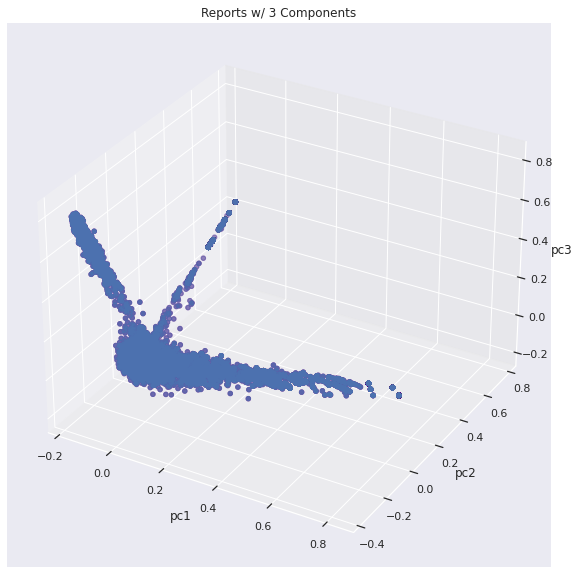

In [29]:
fig = plt.figure(figsize = (15, 10))
ax = plt.axes(projection ="3d")

x = reports_3d_df['pc1']
y = reports_3d_df['pc2']
z = reports_3d_df['pc3']

ax.scatter3D(x, y, z, color = "purple")
plt.title("Reports w/ 3 Components")

ax.set_xlabel("pc1")
ax.set_ylabel("pc2")
ax.set_zlabel("pc3")

ax.scatter(x, y, z)

plt.show()

In [30]:
#Whoa^^

In [31]:
lsa = TruncatedSVD(18)

lsa_tfidf_speech = lsa.fit(sfx)

In [32]:
lsa_tfidf_speech.components_

array([[ 3.25842382e-02,  4.87190608e-02,  1.17691768e-02, ...,
         3.38570353e-02,  1.35925785e-02,  2.71107319e-02],
       [ 3.75900138e-02,  4.73671719e-02, -6.87505157e-03, ...,
        -1.77525527e-02, -1.18483528e-03, -5.85223555e-03],
       [ 2.79246100e-02,  4.25761891e-02,  1.00725693e-02, ...,
         4.31259299e-02,  7.03331644e-03,  4.29070731e-02],
       ...,
       [-2.25701424e-02, -4.13815266e-02, -8.14165741e-03, ...,
         4.44709275e-03, -1.53740858e-05, -1.61330605e-01],
       [ 1.56237645e-02,  3.74124073e-02,  5.00631981e-03, ...,
         2.02262908e-02, -1.07815289e-02, -4.19796703e-03],
       [-3.66754058e-02,  7.43459880e-03,  5.17375064e-03, ...,
        -1.10121183e-01, -2.38835834e-02, -3.05744262e-02]])

In [33]:
#speeches_tfidf.get_feature_names()

In [34]:
lsa_tfidf_speech.transform(sfx)

array([[ 0.07793871, -0.01166904, -0.01709908, ..., -0.00741277,
        -0.05035944,  0.10019073],
       [ 0.55191488,  0.02155848, -0.42145468, ..., -0.02663297,
        -0.4012577 ,  0.10975735],
       [ 0.24826609, -0.1505813 , -0.18855481, ...,  0.04546702,
        -0.07935118, -0.04971098],
       ...,
       [ 0.66256099,  0.01898142,  0.52051006, ..., -0.48040764,
         0.04900646, -0.03422554],
       [ 2.60057571, -0.16437832, -0.11395306, ..., -0.38951279,
         0.10562187,  0.81333963],
       [ 0.03466416,  0.00346956, -0.00986407, ..., -0.07442937,
         0.06039143,  0.04545295]])

In [35]:
nmf = NMF(18)

nmf_tfidf_speech = lsa.fit(sfx)

In [36]:
nmf_tfidf_speech.components_

array([[ 3.25842382e-02,  4.87190609e-02,  1.17691767e-02, ...,
         3.38570353e-02,  1.35925786e-02,  2.71107321e-02],
       [ 3.75899648e-02,  4.73669288e-02, -6.87509007e-03, ...,
        -1.77524630e-02, -1.18480529e-03, -5.85221945e-03],
       [ 2.79244341e-02,  4.25772359e-02,  1.00728115e-02, ...,
         4.31252901e-02,  7.03347751e-03,  4.29066919e-02],
       ...,
       [-2.48345533e-02, -4.72042706e-02, -8.26321776e-03, ...,
         4.36599542e-03, -2.97637786e-03, -1.64266311e-01],
       [ 1.02620175e-02,  3.78896964e-02,  7.69033267e-03, ...,
         1.61960785e-02, -1.41894848e-02, -2.33777971e-02],
       [-3.64239246e-02,  8.43957627e-05,  3.68027881e-03, ...,
        -9.59029077e-02, -1.48195458e-02, -6.88375467e-03]])

In [37]:
nmf_tfidf_speech.transform(sfx)

array([[ 0.07793871, -0.01166877, -0.01710036, ...,  0.01220609,
        -0.06844481,  0.14347591],
       [ 0.55191488,  0.02155962, -0.42146447, ...,  0.05786789,
        -0.43011745,  0.2519942 ],
       [ 0.24826609, -0.15058149, -0.18855257, ...,  0.03525752,
        -0.052645  , -0.14032634],
       ...,
       [ 0.66256099,  0.01898256,  0.5204984 , ..., -0.45462057,
        -0.03729269,  0.13677463],
       [ 2.60057571, -0.16437798, -0.11395474, ..., -0.36118965,
         0.10118401,  0.77505471],
       [ 0.03466416,  0.00346956, -0.00986189, ..., -0.07899717,
         0.05558265,  0.04444913]])

In [38]:
sfx_xpose = speeches_tfidf.fit_transform(speech_tokens).transpose()

In [39]:
speech_corpus = matutils.Sparse2Corpus(sfx_xpose)
speech_id2word = dict((v,k) for k,v in speeches_tfidf.vocabulary_.items())
speech_lda = models.LdaModel(corpus=speech_corpus, num_topics=18, id2word=speech_id2word)

speech_lda.print_topics()

[(0,
  '0.085*"nature" + 0.047*"dr" + 0.042*"general" + 0.038*"state" + 0.037*"level segment" + 0.037*"high level segment" + 0.037*"statement" + 0.037*"solutions" + 0.037*"segment" + 0.036*"high level"'),
 (1,
  '0.086*"including" + 0.066*"needs" + 0.059*"financing" + 0.043*"united kingdom" + 0.041*"kingdom" + 0.040*"fossil" + 0.040*"funding" + 0.039*"scale" + 0.038*"thank" + 0.038*"united"'),
 (2,
  '0.088*"cop" + 0.079*"islands" + 0.070*"low" + 0.070*"small" + 0.068*"states" + 0.058*"warming" + 0.056*"countries" + 0.055*"impacts" + 0.042*"commitments" + 0.028*"actions"'),
 (3,
  '0.088*"uk" + 0.072*"november" + 0.069*"glasgow" + 0.051*"consequences" + 0.051*"way" + 0.046*"deliver" + 0.043*"effective" + 0.040*"ambitious" + 0.032*"world" + 0.029*"address"'),
 (4,
  '0.073*"based" + 0.060*"emissions" + 0.045*"policies" + 0.040*"fuel" + 0.036*"reduction" + 0.036*"fossil" + 0.032*"ambitious" + 0.028*"current" + 0.026*"sector" + 0.017*"contribution"'),
 (5,
  '0.021*"need" + 0.018*"climate

In [40]:
#[doc for doc in speech_lda[speech_corpus]]